In [2]:
import torch
import os
import math
import numpy as np
import pandas as pd
import math

import esm
from utils import refdb_find_shift, refdb_get_seq, get_HA_shifts, get_shifts, shiftx_get_cs_seq, shiftx_get_shift_re
from utils import align_bmrb_pdb
from model import PLM_CS

### Load ESM model (A Protein Language Model)
In the data processing process, the ESM model is used in advance to convert the sequence to embeddings

In [3]:
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()

### Load the pre-trained regression model for Chemical Shift Prediciton
This regression model use embeddings from ESM as input, and output the chemical shifts of a certain atom (CA, CB, C, N, H, HA)

In [4]:
atom_types = ["CA", "CB", "C", "N", "H", "HA"]
model = {}
for atom in atom_types:
    model[atom] = PLM_CS(1280, 512, 8, 0.1)
    file = os.path.join("plm_cs", "ckpt", "model_ckpt", "reg_" + atom.lower() + ".pth")
    model[atom].load_state_dict(torch.load(file, map_location=torch.device('cpu')))
    model[atom].eval()

/var/folders/w9/rf1jnr1d2xq0kp0knwvbm68w0000gn/T/ipykernel_99069/315533317.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model[atom].load_state_dict(torch.load(file, m

### A simple example: A sequence with 21 residues

In [5]:
sequence="MVKVYAPASSANMSVLIQDLM"    # test sequence
output_file = os.path.join("result", "result_test.csv")    # output file path and name

idx_repr = 33 # Using the output of the 33-rd layer as the embedding (do not change)
data = [("protein1", sequence)] 
batch_labels, batch_strs, batch_tokens = batch_converter(data)
with torch.no_grad():
    out_esm = esm_model(batch_tokens, repr_layers=[idx_repr], return_contacts=False)  

token_representations = out_esm["representations"][idx_repr]
embedding = token_representations[:, 1:-1, :].squeeze()
padding_mask = torch.zeros(512).bool()
padding_mask[:embedding.shape[0]] = True
embedding = torch.nn.functional.pad(embedding, (0, 0, 0, 512 - embedding.shape[0]))
mask = torch.tensor([True]*len(sequence))
mask = torch.nn.functional.pad(mask, (0, 512 - mask.shape[0]), value=False)
padding_mask = padding_mask.unsqueeze(0)

df = {"sequence": list(sequence), "CA": [0]*len(sequence), "CB": [0]*len(sequence), "C": [0]*len(sequence), "N": [0]*len(sequence), "H": [0]*len(sequence), "HA": [0]*len(sequence)}

for atom_type in atom_types:
    model_atom = model[atom_type]
    out = model_atom(embedding.unsqueeze(0), padding_mask)
    pred = out.squeeze(2).squeeze(0)[mask]
    df[atom_type] = pred.tolist()

df = pd.DataFrame(df)
df.to_csv(output_file)

### Evaluation on the ShiftX test set

In [38]:
def test_on_shiftxfile(file_path, out_path, atom_types):
    # For each file in the ShiftX dataset, calculate the RMSE of the predicted chemical shifts
    # file_path: the path of the input SHIFTX file
    # out_path: the path of the output file
    # atom_types: a list of atom types to be predicted
    # return: a list of RMSEs for each atom type
    # Note: the output file will be saved in the out_path folder with the same name as the input file
    #       and the extension changed to .csv

    bmrb_seq = refdb_get_seq(file_path)
    s, e = refdb_find_shift(file_path)
    #cs_seq = refdb_get_cs_seq(file_path, s, e)
    #bmrb_seq = refdb_get_seq(file_path)
    cs_seq = shiftx_get_cs_seq(file_path, s, e)
    matched = align_bmrb_pdb(bmrb_seq, cs_seq)
    six_rmse = []

    idx_repr = 33 # Using the output of the 33-rd layer as the embedding (do not change)
   
    if '_' not in bmrb_seq:
        df = {'CA_label':[], 'CA_pred':[], 'CB_label':[], 'CB_pred':[], 'C_label':[], 'C_pred':[], 'N_label':[], 'N_pred':[], 'HA_label':[], 'HA_pred':[], 'H_label':[], 'H_pred':[], }
        for atom_type in atom_types:
            shift, mask = shiftx_get_shift_re(file_path, s, e, bmrb_seq, matched, atom_type)
            label= torch.tensor(shift)
            mask = torch.tensor(mask)
            label = torch.nn.functional.pad(label, (0, 512-label.shape[0]))
            data = [("protein1", bmrb_seq)]

            batch_labels, batch_strs, batch_tokens = batch_converter(data) 
            with torch.no_grad():
                out_esm = esm_model(batch_tokens, repr_layers=[idx_repr], return_contacts=False)  
            token_representations = out_esm["representations"][idx_repr]
            embedding = token_representations[:, 1:-1, :].squeeze()
            padding_mask = torch.zeros(512).bool()
            padding_mask[:embedding.shape[0]] = True
            padding_mask = padding_mask.unsqueeze(0)
            embedding = torch.nn.functional.pad(embedding, (0, 0, 0, 512 - embedding.shape[0]))
            mask = torch.nn.functional.pad(mask, (0, 512 - mask.shape[0]), value=False)
            
            out = model[atom_type](embedding.unsqueeze(0), padding_mask)
            #out = out.squeeze(2).squeeze(0)
            out = out.squeeze(2).squeeze(0)[0:len(bmrb_seq)]
            label = label[0:len(bmrb_seq)]
            mask = mask[0:len(bmrb_seq)]
            
            loss_func = torch.nn.MSELoss()
            loss = loss_func(out[mask], label[mask])
            #loss = loss_func(out, label)
            rmse = math.sqrt(loss.item())
            a = out.detach().numpy()
            b = label.detach().numpy()
            df[atom_type+'_pred'] = a
            df[atom_type+'_label']= b
            
            six_rmse.append(rmse)
            
        print(file_path + " Inference finished, RMSE is: " + ", ".join("{:.2f}".format(x) for x in six_rmse))
    df = pd.DataFrame(df)
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    file_name = os.path.basename(file_path)
    out_file = os.path.join(out_path, file_name+".csv")
    df.to_csv(out_file)
    return six_rmse

Test each shiftx file and save results

In [40]:
path_shiftx_testset = "./dataset/shiftx_test_set"
path_shiftx_results = "./result/shiftx_test_set"

all_six_rmse = [[], [], [], [], [], []]
for root, directories, files in os.walk(path_shiftx_testset):
    for file in files:
        if file.startswith("."):
            continue
        file_path = os.path.join(path_shiftx_testset, file)
        six_rmse = test_on_shiftxfile(file_path, path_shiftx_results, atom_types)
        for i in range(len(six_rmse)):
            if not math.isnan(six_rmse[i]):
                all_six_rmse[i].append(six_rmse[i])

print("Average RMSE for CA: {:.2f}".format(np.mean(all_six_rmse[0])))
print("Average RMSE for CB: {:.2f}".format(np.mean(all_six_rmse[1])))
print("Average RMSE for C: {:.2f}".format(np.mean(all_six_rmse[2])))
print("Average RMSE for N: {:.2f}".format(np.mean(all_six_rmse[3])))
print("Average RMSE for H: {:.2f}".format(np.mean(all_six_rmse[4])))
print("Average RMSE for HA: {:.2f}".format(np.mean(all_six_rmse[5])))


/var/folders/w9/rf1jnr1d2xq0kp0knwvbm68w0000gn/T/ipykernel_99069/4135926605.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label= torch.tensor(shift)
/var/folders/w9/rf1jnr1d2xq0kp0knwvbm68w0000gn/T/ipykernel_99069/4135926605.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask)


./dataset/shiftx_test_set/A018_bmr4879.str.corr.pdbresno Inference finished, RMSE is: 1.48, 1.61, 1.06, 3.73, 0.56, 0.40
./dataset/shiftx_test_set/A040_bmr5358.str.corr.pdbresno Inference finished, RMSE is: 0.52, nan, 0.80, 0.83, 0.28, 0.18
./dataset/shiftx_test_set/A054_bmr2208.str.corr.pdbresno Inference finished, RMSE is: 1.08, nan, 1.05, 1.94, 0.28, 0.30
./dataset/shiftx_test_set/A041_bmr4083.str.corr.pdbresno Inference finished, RMSE is: 0.51, 0.96, nan, 0.93, 0.13, 0.10
./dataset/shiftx_test_set/A045_bmr6034.str.corr.pdbresno Inference finished, RMSE is: 1.31, 1.76, 1.19, 3.90, 0.59, nan
./dataset/shiftx_test_set/A059_bmr6024.str.corr.pdbresno Inference finished, RMSE is: 0.76, 1.03, 0.85, 1.09, 0.14, nan
./dataset/shiftx_test_set/A038_bmr6032.str.corr.pdbresno Inference finished, RMSE is: 0.43, 0.43, 0.52, 0.62, 0.19, 0.17
./dataset/shiftx_test_set/A014_bmr15757.str.corr.pdbresno Inference finished, RMSE is: 1.57, 1.71, 1.40, 3.77, 0.65, 0.36
./dataset/shiftx_test_set/A025_bmr15

### Evaluation on the solution-NMR test set
Since some files in this dataset contain more than one sequence, we make a prediction for each sequence, so the number of output files may exceed the number of input files.

In [41]:
from utils import extract_protein_sequence

def test_on_solutionnmr(file_path, out_path, atom_types):
    bmrb_seq_list = extract_protein_sequence(file_path)

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    six_rmse = []
    for i, bmrb_seq in enumerate(bmrb_seq_list):
        if '_' not in bmrb_seq and len(bmrb_seq) < 512:
            data = [("protein1", bmrb_seq_list[i])]
            batch_labels, batch_strs, batch_tokens = batch_converter(data)
            with torch.no_grad():
                results = esm_model(batch_tokens, repr_layers=[idx_repr], return_contacts=True)
            token_representations = results["representations"][idx_repr]
            embedding = token_representations[:, 1:-1, :].squeeze()
            embedding = torch.nn.functional.pad(embedding, (0, 0, 0, 512 - embedding.shape[0]))
            
            df = {'CA_label':[], 'CA_pred':[], 'CB_label':[], 'CB_pred':[], 'C_label':[], 'C_pred':[], 'N_label':[], 'N_pred':[], 'HA_label':[], 'HA_pred':[], 'H_label':[], 'H_pred':[], }
            for atom_type in atom_types:
                if atom_type == "HA":
                    shifts, masks = get_HA_shifts(file_path, "HA", bmrb_seq_list)
                else:
                    shifts, masks = get_shifts(file_path, atom_type, bmrb_seq_list)
                label= torch.tensor(shifts[i])
                mask = torch.tensor(masks[i])
                padding_mask = torch.zeros(512).bool()
                padding_mask[:label.shape[0]] = True
                label = torch.nn.functional.pad(label, (0, 512 - label.shape[0]))
                mask = torch.nn.functional.pad(mask, (0, 512 - mask.shape[0]), value=False)
                padding_mask = padding_mask.unsqueeze(0)
                
                out = model[atom_type](embedding.unsqueeze(0), padding_mask)
                
                out = out.squeeze(2).squeeze(0)[0:len(bmrb_seq)]
                label = label[0:len(bmrb_seq)]
                mask = mask[0:len(bmrb_seq)]
                
                loss_func = torch.nn.MSELoss()
                loss = loss_func(out[mask], label[mask])
                rmse = math.sqrt(loss.item())
                a = out.detach().numpy()
                b = label.detach().numpy()
                df[atom_type+'_pred'] = a
                df[atom_type+'_label']= b
                # print(file_path + atom_type+" Inference finished, rmse is: ", rmse)
                six_rmse.append(rmse)

            df = pd.DataFrame(df)
            
            file_name = os.path.basename(file_path)
            if i > 0:
                out_file = os.path.join(out_path, file_name+"_"+str(i)+".csv")
                print(file_path + "_"+str(i)+" Inference finished, RMSE is: " + ", ".join("{:.2f}".format(x) for x in six_rmse[6*i:6*i+6]))
            else:
                out_file = os.path.join(out_path, file_name+".csv")
                print(file_path + " Inference finished, RMSE is: " + ", ".join("{:.2f}".format(x) for x in six_rmse))
            df.to_csv(out_file)
    
    return six_rmse

Test each solution_nmr_test_set file

In [42]:
path_solution_testset = "./dataset/solution_nmr_test_set"
path_solution_results = "./result/solution_nmr_test_set"

all_six_rmse = [[], [], [], [], [], []]

for root, directories, files in os.walk(path_solution_testset):
    for file in files:
        if file.startswith("."):
            continue
        file_path = os.path.join(path_solution_testset, file)
        six_rmse = test_on_solutionnmr(file_path, path_solution_results, atom_types)

        if file.split(".")[0] != "11471":
            # The PDB file corresponding to 11471 has two chains, but both chains are part of the first sequence in bmrb, so it is calculated twice
            for i in range(len(six_rmse)):
                # if file.split(".")[0] not in exclude_bmrb or i not in exclude_bmrb[file.split(".")[0]]:
                if not math.isnan(six_rmse[i]):
                    if i<6:
                        all_six_rmse[i].append(six_rmse[i])
                    else:
                        all_six_rmse[i-6].append(six_rmse[i])
        elif file.split(".")[0] == "4246" or file.split(".")[0] == "7125":
            # Both chains of the two BMRB files are in the test set
            for i in range(len(six_rmse)):
                if not math.isnan(six_rmse[i]):
                    if i<6:
                        all_six_rmse[i].append(six_rmse[i])
                    else:
                        all_six_rmse[i-6].append(six_rmse[i-6])
        else:
            for i in range(6):
                if not math.isnan(six_rmse[i]):
                    all_six_rmse[i].append(six_rmse[i])        

./dataset/solution_nmr_test_set/11491.str Inference finished, RMSE is: 0.92, 0.84, 0.96, 2.28, 0.34, 0.22
./dataset/solution_nmr_test_set/16117.str Inference finished, RMSE is: 2.53, 2.17, 2.31, 4.82, 0.89, 0.76
./dataset/solution_nmr_test_set/16116.str Inference finished, RMSE is: 0.76, 0.63, 0.97, 2.39, 0.29, 0.20
./dataset/solution_nmr_test_set/7158.str Inference finished, RMSE is: 1.08, 1.65, 1.66, 4.10, 0.37, 0.22
./dataset/solution_nmr_test_set/11531.str Inference finished, RMSE is: 1.29, 1.28, 1.27, 3.72, 0.62, 0.53
./dataset/solution_nmr_test_set/11525.str Inference finished, RMSE is: 1.48, 0.88, 1.22, 2.77, 0.55, 0.21
./dataset/solution_nmr_test_set/17752.str Inference finished, RMSE is: 0.90, 2.33, 1.19, 2.78, 0.43, 0.25
./dataset/solution_nmr_test_set/16114.str Inference finished, RMSE is: 2.57, 2.73, nan, 1.61, 0.24, 0.21
./dataset/solution_nmr_test_set/11478.str Inference finished, RMSE is: 1.13, 2.03, 1.41, 2.49, 0.27, 0.20
./dataset/solution_nmr_test_set/11487.str Infere

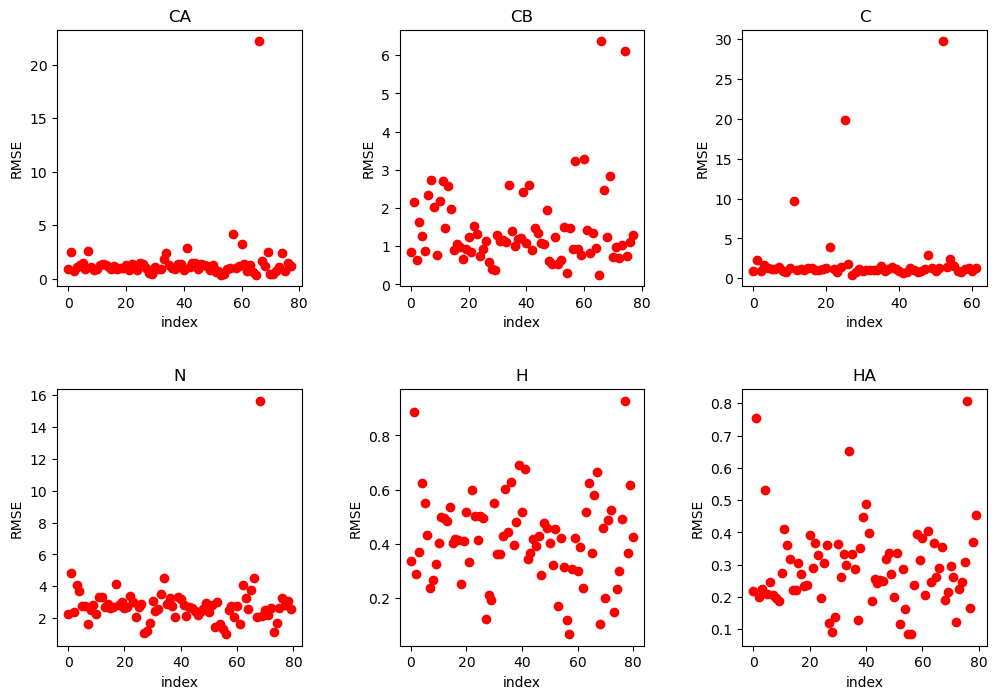

In [43]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(axes.flatten()):
    ax.plot(all_six_rmse[i], 'ro')
    ax.set_title(atom_types[i])
    ax.set_xlabel('index')
    ax.set_ylabel('RMSE')
plt.show()

#### A simple statistical analysis on the RMSE values
Before analyzing the mean RMSE values, we remove obvious outliers from the dataset. This step can be applied under other settings as well. For example, in the paper, we compare the results of SHIFTX2 and PLM-CS, removing data with significantly large RMSE values from both methods.

In [47]:
def mean_without_anomalies(data):
    """
    Calculate the mean of the dataset excluding outliers based on the 3-sigma rule.

    Parameters:
    data (array-like): The dataset (should be a 1D array or list of numerical values).
    
    Returns:
    float: The mean of the data excluding outliers. If the dataset is empty or 
           all values are outliers, returns None.
    """
    if len(data) == 0:
        return None  # Handle empty dataset
    
    data = np.array(data)
    
    mean = np.mean(data)
    std = np.std(data)
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    print(f"Remove {len(data)-len(filtered_data)} outliers from {len(data)} data points")

    if len(filtered_data) == 0:
        return None  # If all values are outliers, return None

    return np.mean(filtered_data)

print("Average RMSE for CA: {:.2f}".format(mean_without_anomalies(all_six_rmse[0])))
print("Average RMSE for CB: {:.2f}".format(mean_without_anomalies(all_six_rmse[1])))
print("Average RMSE for C: {:.2f}".format(mean_without_anomalies(all_six_rmse[2])))
print("Average RMSE for N: {:.2f}".format(mean_without_anomalies(all_six_rmse[3])))
print("Average RMSE for H: {:.2f}".format(mean_without_anomalies(all_six_rmse[4])))
print("Average RMSE for HA: {:.2f}".format(mean_without_anomalies(all_six_rmse[5])))


Remove 1 outliers from 78 data points
Average RMSE for CA: 1.22
Remove 1 outliers from 78 data points
Average RMSE for CB: 1.38
Remove 3 outliers from 62 data points
Average RMSE for C: 1.24
Remove 1 outliers from 80 data points
Average RMSE for N: 2.68
Remove 0 outliers from 81 data points
Average RMSE for H: 0.42
Remove 0 outliers from 80 data points
Average RMSE for HA: 0.29
